In [ ]:
# only run this cell in new environment
!pip install -U -q PyDrive
!pip install lightgbm
!pip install --user mlxtend
!pip install xgboost
!pip install pandas_profiling==3.6.3

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import sys
# append directory so that colab can find the common util libraries
sys.path.append('/content/drive/My Drive/w210-capstone/Colab')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Code to read csv file from Google Drive into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
from datetime import datetime

import pickle
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split

from pandas_profiling import ProfileReport
# from google.colab import files

## Data Extraction

In [4]:
# Extract data from Nat2021us_small_200000.txt and construct a dataframe

# it takes two minutes to load this 
def load_file_extract_data():
    col_mapping = []
    col_mapping.append([9,  12, 'birth_year']) # 2021
    col_mapping.append([13, 14, 'birth_month']) # 01=Jan, 12=Dec
    col_mapping.append([19, 20, 'time_of_birth']) # HH. 9999=Not Staetd
    col_mapping.append([23, 23, 'birth_day_of_week']) # 1=Sunday, 7=Saturday
    col_mapping.append([32, 32, 'birth_place']) # 1=hospital, 2=freestanding birth center, 3=home(intended), ... 9=Unknown
    col_mapping.append([75, 76, 'mother_age']) # 12=10-12years-old, 13=13, ... 50=50 and over
    col_mapping.append([84, 84, 'mother_nativity']) # 1=born in the US, 2=born outside the US, 3=Unknown
    col_mapping.append([104,104,'residence_status'])
    col_mapping.append([105,106,'mother_race1']) # detailed breakdown, 31 values
    col_mapping.append([107,107,'mother_race2']) # only 6 groups
    col_mapping.append([108,109,'mother_race3']) # 15 groups
    col_mapping.append([115,115,'mother_hispanic_origin']) # non-hispanic, mexican, puerto rican, etc
    col_mapping.append([117,117,'mother_hispanic_race']) # hispanic, non-hispanic-white, non-hispanic black, etc
    col_mapping.append([119,119,'paternity_acknowledged']) # Y/N, U=unknonw, X=N/A
    col_mapping.append([120,120,'marital_status']) # 1=Married, 2=Unmarried, 3=Unmarried not living together, 9=Unknown
    col_mapping.append([124,124,'mother_education']) # 1=8th grade or less, 2=9th-12th grade, ... 9=Unknown
    col_mapping.append([147,148,'father_age']) # 09-98, 99-unknown or not stated
    col_mapping.append([151,152,'father_race1']) # detailed breakdown, 31 values
    col_mapping.append([153,153,'father_race2']) # only 6 groups
    col_mapping.append([154,155,'father_race3']) # 15 groups
    col_mapping.append([159,159,'father_hispanic_origin']) # non-hispanic, mexican, puerto rican, etc
    col_mapping.append([162,162,'father_hispanic_race']) # hispanic, non-hispanic-white, non-hispanic black, etc
    col_mapping.append([163,163,'father_education']) # 1=8th grade or less, 2=9th-12th grade, ... 9=Unknown
    col_mapping.append([171,172,'prior_births_now_living']) # 0-30 number of children living from previous births, 99=Unknown
    col_mapping.append([173,174,'prior_births_now_dead']) # 0-30 number of children dead from previous births, 99=Unknown
    col_mapping.append([182,182,'total_birth_order']) # 1-7 total birth order, 8 or more total births, 9=Unknown
    col_mapping.append([201,202,'interval_since_last_live_birth']) # 00(zero-to-3months plural delivery), 01=04-11month, 02=12-17months
    col_mapping.append([227,227,'month_prenatal_care_began']) # 1=1st-3rd month, 2=4th-6th month, 3=7th-final, 4=no prenatal, 5=unknown
    col_mapping.append([242,243,'number_of_prenatal_visits']) # 00-98, 99=Unknown
    col_mapping.append([251,251,'wic']) # Y/N/U, Women Infant Care Program
    col_mapping.append([261,261,'cigarettes_before_pregnancy']) # 0=Non-smoker, 1=1-5, 2=6-10, .. 5=41 or more, 6=Unknown
    col_mapping.append([262,262,'cigarettes_1st_trimester']) # 0=Non-smoker, 1=1-5, 2=6-10, .. 5=41 or more, 6=Unknown
    col_mapping.append([263,263,'cigarettes_2nd_trimester']) # 0=Non-smoker, 1=1-5, 2=6-10, .. 5=41 or more, 6=Unknown
    col_mapping.append([264,264,'cigarettes_3rd_trimester']) # 0=Non-smoker, 1=1-5, 2=6-10, .. 5=41 or more, 6=Unknown
    col_mapping.append([280,281,'mother_height_in_total_inches']) # 30-78, 99=Unknown
    col_mapping.append([287,287,'bmi']) # 1=Underweigth<18.5, 2=Normal18.5-24.9, ... 9=Unknown
    col_mapping.append([292,294,'prepregnancy_weight']) # 075-375
    col_mapping.append([299,301,'delivery_weight']) # 100-400, 999=Unknown
    col_mapping.append([304,305,'weight_gain']) # 00-97, 98=98 and over, 99=Unknown
    col_mapping.append([306,306,'weight_gain_group']) # 1=less than 11lbs, 2=11-20, 9=Unknown

    col_mapping.append([313,313,'prepregnancy_diabetes']) # Y/N/U
    col_mapping.append([314,314,'gestational_diabetes']) # Y/N/U
    col_mapping.append([315,315,'prepregnancy_hypertension']) # Y/N/U
    col_mapping.append([316,316,'gestational_hypertension']) # Y/N/U
    col_mapping.append([317,317,'hypertension_eclampsia']) # Y/N/U
    col_mapping.append([318,318,'previous_preterm_birth']) # Y/N/U
    col_mapping.append([325,325,'infertility_treatment_used']) # Y/N/U
    col_mapping.append([326,326,'fertility_enhancing_drugs']) # Y/N/X/U, X=N/A
    col_mapping.append([327,327,'asst_reproductive_technology']) # Y/N/X/U, X=N/A
    col_mapping.append([331,331,'previous_cesarean']) # Y/N/U
    col_mapping.append([332,333,'number_of_previous_cesareans']) # 00=None, 0-30, 99=Unknowns
    col_mapping.append([337,337,'no_risk_factors_reported']) #1=True, 0=False, 9=Not reported

    col_mapping.append([343,343,'gonorrhea']) # Y/N/U
    col_mapping.append([344,344,'syphilis']) # Y/N/U
    col_mapping.append([345,345,'chlamydia']) # Y/N/U
    col_mapping.append([346,346,'hepatitis_b']) # Y/N/U
    col_mapping.append([347,347,'hepatitis_c']) # Y/N/U

    col_mapping.append([360,360,'successful_external_cephalic_version']) # Y/N/U
    col_mapping.append([361,361,'failed_external_cephalic_version']) # Y/N/U

    col_mapping.append([383,383,'induction_of_labor']) # Y/N/U
    col_mapping.append([384,384,'augmentation_of_labor']) # Y/N/U
    col_mapping.append([385,385,'steriods']) # Y/N/U
    col_mapping.append([386,386,'antibiotics']) # Y/N/U
    col_mapping.append([387,387,'chorioamnionitis']) # Y/N/U
    col_mapping.append([388,388,'anesthesia']) # Y/N/U
    col_mapping.append([395,395,'no_characteristics_of_labor_reported']) # 0=True, 1=False, 9=Not-Reported
    col_mapping.append([401,401,'fetal_presentation_at_delivery']) # 1=Cephalic, 2=Breech, 3=Other, 9=Unknown
    col_mapping.append([408,408,'delivery_method']) # 1=Vaginal, 2=C-Section, 9=Unknown

    col_mapping.append([433,433,'attendant_at_birth']) # 1=MD, 2=OD, 3=CNM, 4=Other Midwife, 5=Other, 9=Unknown

    col_mapping.append([454,454,'pluarality']) # 1=single, 2=twin, 3=tuplet, 4=quadruplet or higher

    col_mapping.append([475,475,'sex_of_infant']) # M, F
    col_mapping.append([477,478,'last_normal_menses_month']) # 01-12, 99=Unknown
    col_mapping.append([481,484,'last_normal_menses_year']) # YYYY

    col_mapping.append([490,491,'combined_gestation_week']) # gestation by week
    col_mapping.append([492,493,'combined_gestation']) # 01=under 20 weeks, 02=20-27, 03=28-31, 04=32-33, ... 99=Unknown

    col_mapping.append([501,502,'obstetric_estimate']) # 01=under 20 weeks, 02=20-27, 03=28-31, 04=32-33, 99=Unknown

    col_mapping.append([504,507,'birth_weight_in_g']) # 0227-8165 grams, 9999=unknown
    col_mapping.append([509,510,'birth_weight1']) # 1=0227-0499g, 2=0500-0999g, etc
    col_mapping.append([509,510,'birth_weight2']) # 1=0227-1499g, 2=1500-2499g, 3=2500-8165g, 4=Unknown
    col_mapping.append([568,568,'infant_living_at_time_of_report']) # Y/N
    col_mapping.append([569,569,'infant_breastfed_at_discharge']) # Y/N


    col_mapping_df = pd.DataFrame(data=col_mapping, columns=['start', "end", 'field_name'])    
    col_mapping_df['start'] = col_mapping_df['start'] - 1 # must minus because read_fwf expects start-1 to end
    col_mapping_df['col_specs'] = list(zip(col_mapping_df.start, col_mapping_df.end))

    col_specs=col_mapping_df.col_specs.values.tolist()
    field_names=col_mapping_df.field_name.values.tolist()
    #col_mapping_df

    # local jupyter df = pd.read_fwf('Nat2021us/Nat2021us_small_200000.txt', colspecs=col_specs, names=field_names)
    #df = pd.read_fwf('/content/drive/MyDrive/MIDS/210/frankie/capstone_childbirth/Nat2021us_zip/Nat2021US.txt', colspecs=col_specs, names=field_names)
    #df = pd.read_fwf('/content/drive/MyDrive/MIDS/210/Datasets/Nat2021US.txt', colspecs=col_specs, names=field_names)
    df = pd.read_fwf('/content/drive/MyDrive/w210-capstone/Nat2021US/Nat2021US.txt', colspecs=col_specs, names=field_names)
    print(df.shape)

    return df

df = load_file_extract_data()

(3669928, 81)


In [5]:
df

,birth_year,birth_month,time_of_birth,birth_day_of_week,birth_place,mother_age,mother_nativity,residence_status,mother_race1,mother_race2,...,last_normal_menses_month,last_normal_menses_year,combined_gestation_week,combined_gestation,obstetric_estimate,birth_weight_in_g,birth_weight1,birth_weight2,infant_living_at_time_of_report,infant_breastfed_at_discharge
0,2021,1,6,7,1,22,1,1,1,1,...,4,2020,39,7,8,3670,8,8,Y,Y
1,2021,1,2,7,1,31,1,2,22,6,...,4,2020,39,7,7,3210,7,7,Y,Y
2,2021,1,2,1,1,29,1,1,1,1,...,3,2020,40,8,8,3997,8,8,Y,Y
3,2021,1,2,1,1,39,1,1,1,1,...,4,2020,39,7,7,3510,8,8,Y,Y
4,2021,1,5,1,1,20,2,1,5,5,...,3,2020,39,7,6,3100,7,7,Y,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3669923,2021,12,19,6,3,35,1,1,13,6,...,3,2021,37,6,6,2807,6,6,Y,Y
3669924,2021,10,5,7,3,29,1,1,2,2,...,99,9999,99,99,99,9999,12,12,Y,U
3669925,2021,12,2,7,1,36,1,1,1,1,...,3,2021,39,7,7,2905,6,6,Y,Y
3669926,2021,6,21,6,3,27,1,1,2,2,...,9,2020,40,8,8,3175,7,7,Y,Y


## Split train, validation, and test

We split the data before EDA so that we can add or drop columns easily during model construction and tuning

In [7]:
X = df.copy()  # keep the original df

# drop unknown weight from the dataset
X = X[X.birth_weight_in_g != 9999]
X = X[X.combined_gestation_week !=99]
y = X[['birth_weight_in_g', 'combined_gestation_week']] # predict the weight in grams, numerical prediction

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) 
X_train.to_csv("/content/drive/MyDrive/w210-capstone/Colab/data_files/x_train_orig.csv", index=False)
y_train.to_csv("/content/drive/MyDrive/w210-capstone/Colab/data_files/y_train_orig.csv", index=False)
X_val.to_csv("/content/drive/MyDrive/w210-capstone/Colab/data_files/x_val_orig.csv", index=False)
y_val.to_csv("/content/drive/MyDrive/w210-capstone/Colab/data_files/y_val_orig.csv", index=False)
X_test.to_csv("/content/drive/MyDrive/w210-capstone/Colab/data_files/x_test_orig.csv", index=False)
y_test.to_csv("/content/drive/MyDrive/w210-capstone/Colab/data_files/y_test_orig.csv", index=False)

# uncomment if running it in local jupyter notebook
'''
X_train.to_csv("data_files/x_train_orig.csv", index=False)
y_train.to_csv("data_files/y_train_orig.csv", index=False)
X_val.to_csv("data_files/x_val_orig.csv", index=False)
y_val.to_csv("data_files/y_val_orig.csv", index=False)
X_test.to_csv("data_files/x_test_orig.csv", index=False)
y_test.to_csv("data_files/y_test_orig.csv", index=False)
'''

print(f"Train feature shape: {X_train.shape}, output shape: {y_train.shape}")
print(f"Val feature shape: {X_val.shape}, output shape: {y_val.shape}")
print(f"Test feature shape: {X_test.shape}, output shape: {y_test.shape}")


Train feature shape: (274848, 81), output shape: (274848, 2)
Val feature shape: (91616, 81), output shape: (91616, 2)
Test feature shape: (3298177, 81), output shape: (3298177, 2)


## Data Profiling

In [27]:
# Data to be used in the EDA
X_EDA = X
y_EDA = y

# set to X and y for full dataset
#X_EDA = X
#y_EDA = y


In [28]:
# Note that the following EDA profile takes a few minutes to generate
def generate_pandas_profile_eda():
    """Function to generate html files containing profiles of the
    training and test data sets for EDA purposes."""

    # Create and save training profile to an html file
    train_profile = ProfileReport(X_EDA, minimal=True, title="Training Data Report", html={"style": {"full_width": True}})
    train_profile.to_file(output_file="/content/drive/MyDrive/w210-capstone/Colab/data_files/train_profile.html")

# uncomment to generate pandas profile HTML
generate_pandas_profile_eda()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

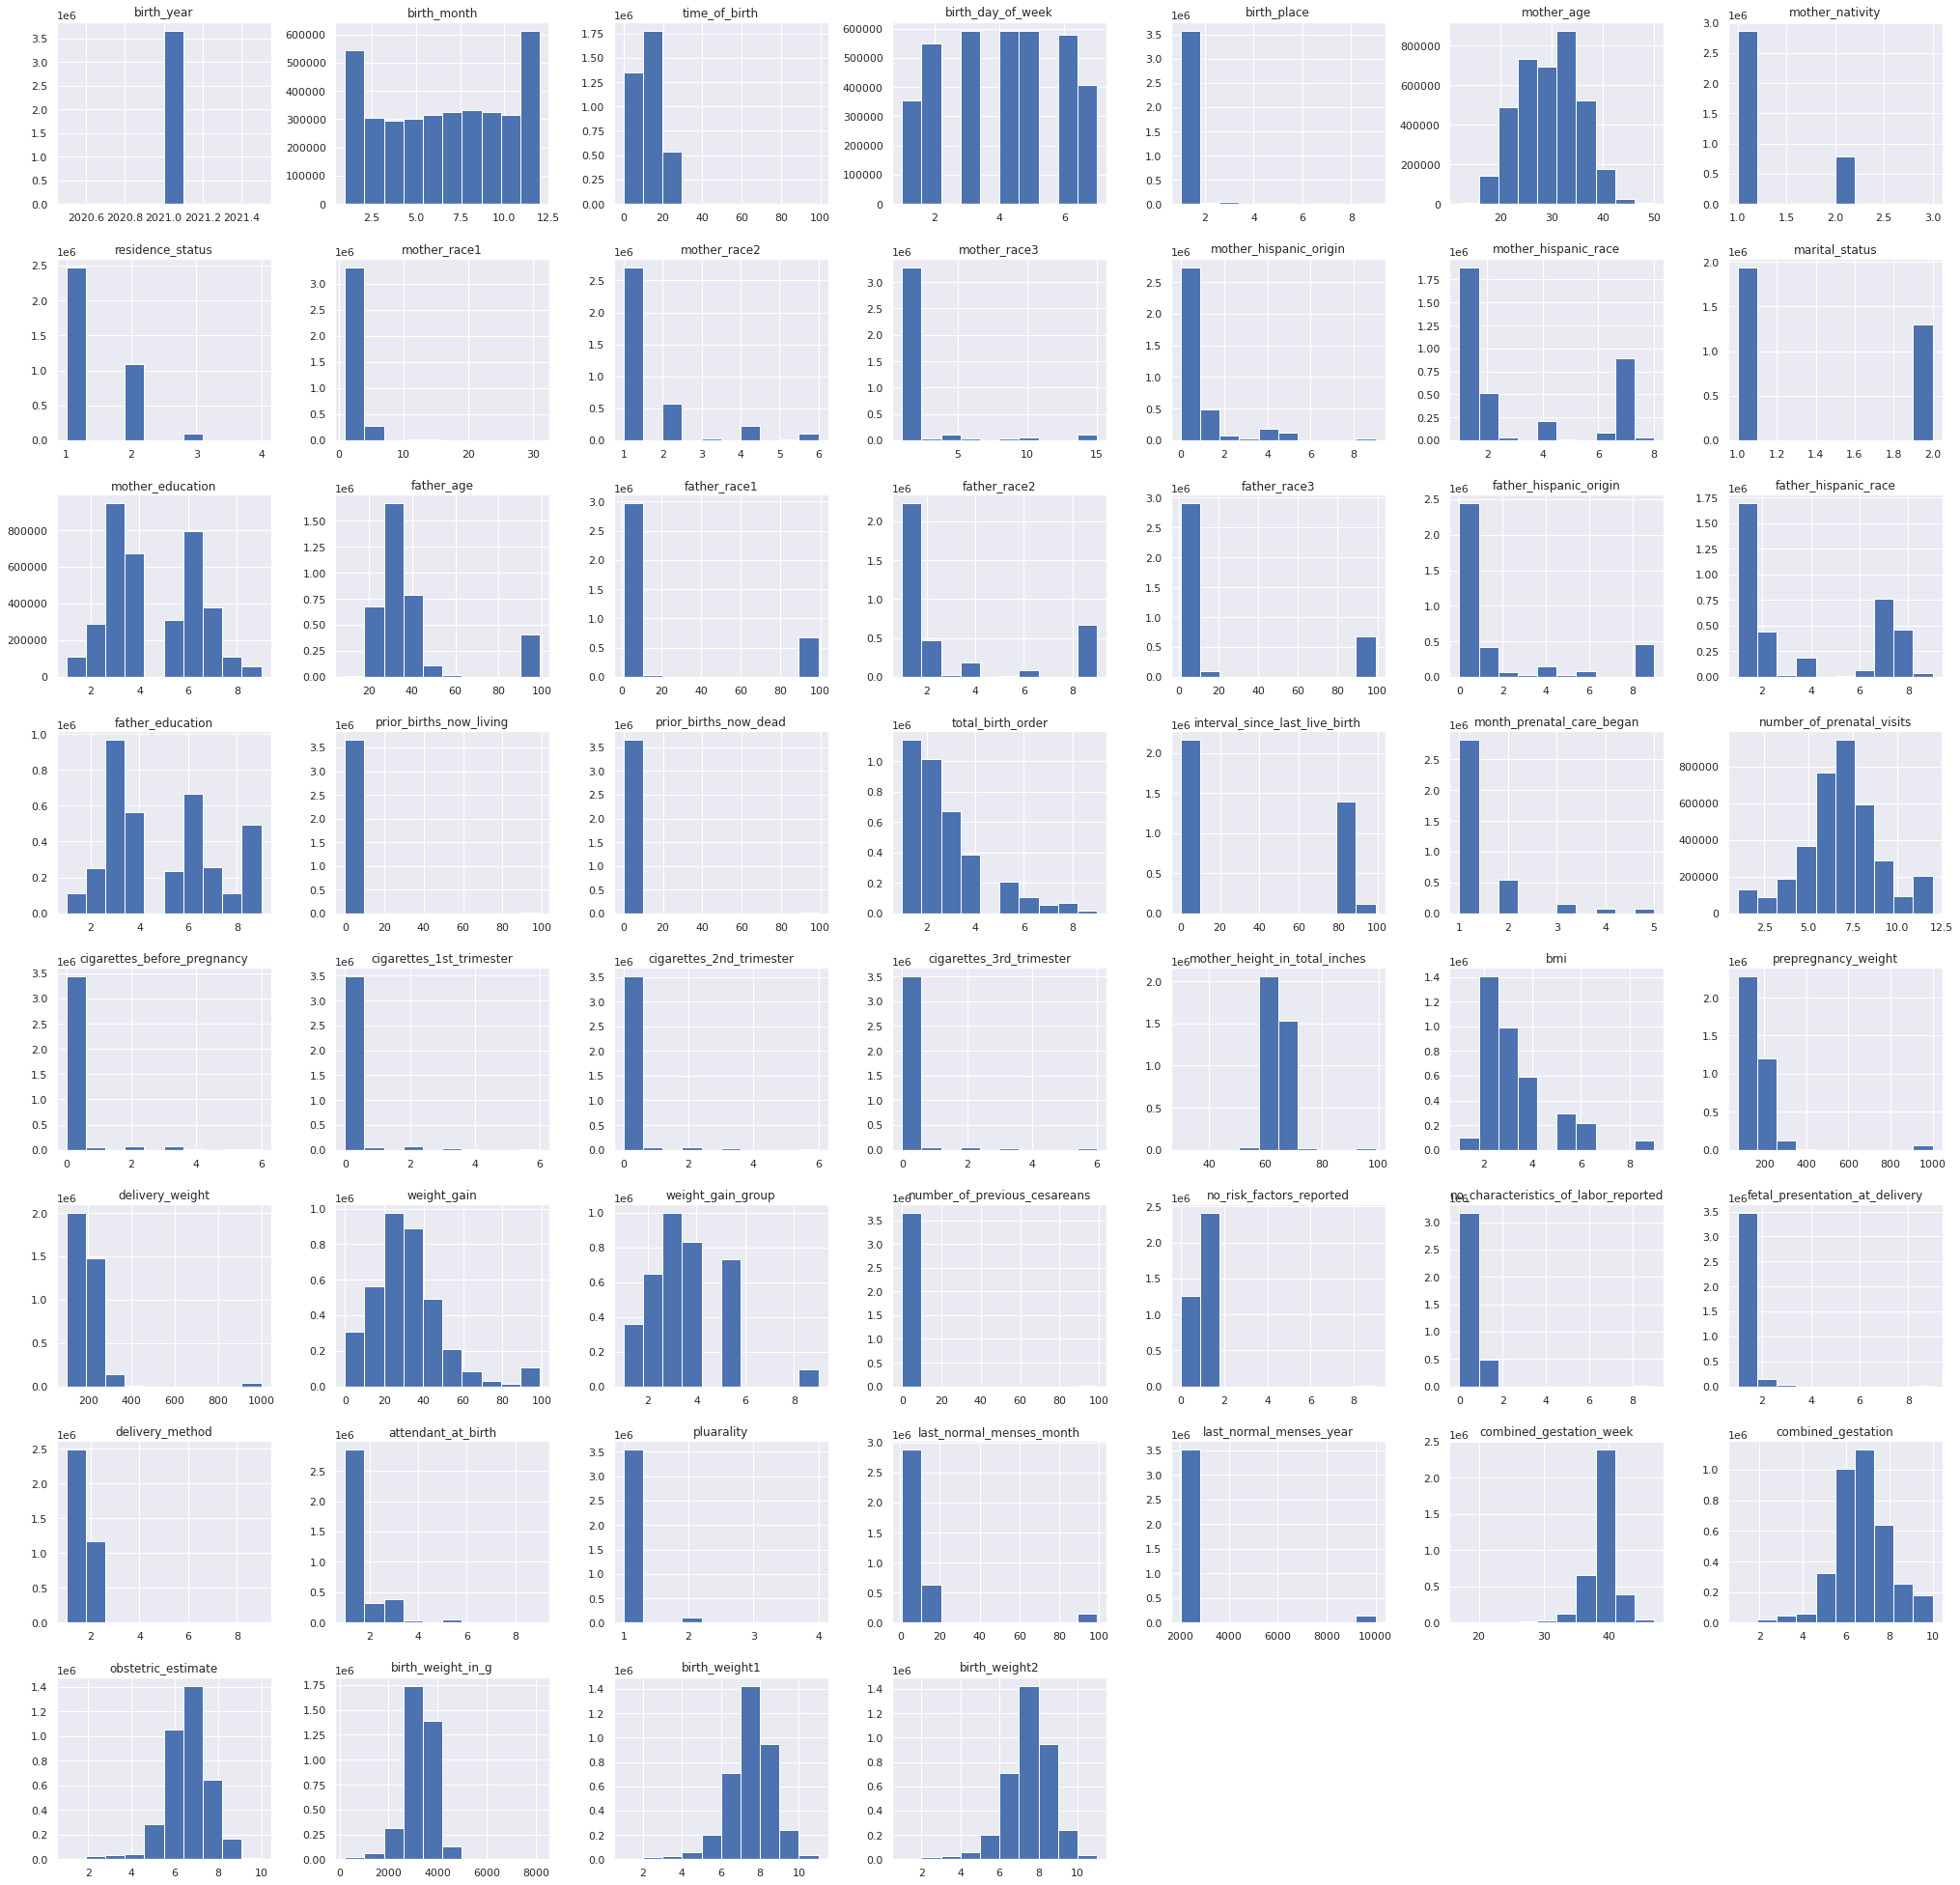

In [30]:
# simple histograms

hist = X_EDA.hist(figsize=(35,35))


## Data Cleaning and Analysis

In [31]:
# remove outcome variables
def remove_outcome_variables(X_features):
    X_features = X_features.drop(['birth_weight1', 'birth_weight2', 'combined_gestation', 'obstetric_estimate'], axis=1, errors='ignore')
    print(X_features.shape)
    return X_features

X_EDA = remove_outcome_variables(X_EDA)


(3664641, 77)


In [32]:
# remove features that are highly skewed

def remove_skewed_features(X_features):
    columns_to_be_dropped = []
    columns_to_be_dropped.append('birth_year') # all values are the same 2021
    columns_to_be_dropped.append('birth_place') # 97.8%
    columns_to_be_dropped.append('prior_births_now_dead') # 98.6%
    columns_to_be_dropped.append('prepregnancy_diabetes') # 98.8%
    columns_to_be_dropped.append('hypertension_eclampsia') # 99.6%
    columns_to_be_dropped.append('asst_reproductive_technology') # 97.6%, X = N/A
    columns_to_be_dropped.append('gonorrhea') # 99.2%
    columns_to_be_dropped.append('syphilis') # 99.4%
    columns_to_be_dropped.append('hepatitis_b') # 99.4%
    columns_to_be_dropped.append('hepatitis_c') # 99.1%
    columns_to_be_dropped.append('successful_external_cephalic_version') # 99.6%
    columns_to_be_dropped.append('failed_external_cephalic_version') # 99.6%
    columns_to_be_dropped.append('chorioamnionitis') # 98.3%
    columns_to_be_dropped.append('infant_living_at_time_of_report') # 99.6%

    X_features = X_features.drop(columns_to_be_dropped, axis=1, errors='ignore')
    print(X_features.shape)
    return X_features

X_EDA = remove_skewed_features(X_EDA)


(3664641, 63)


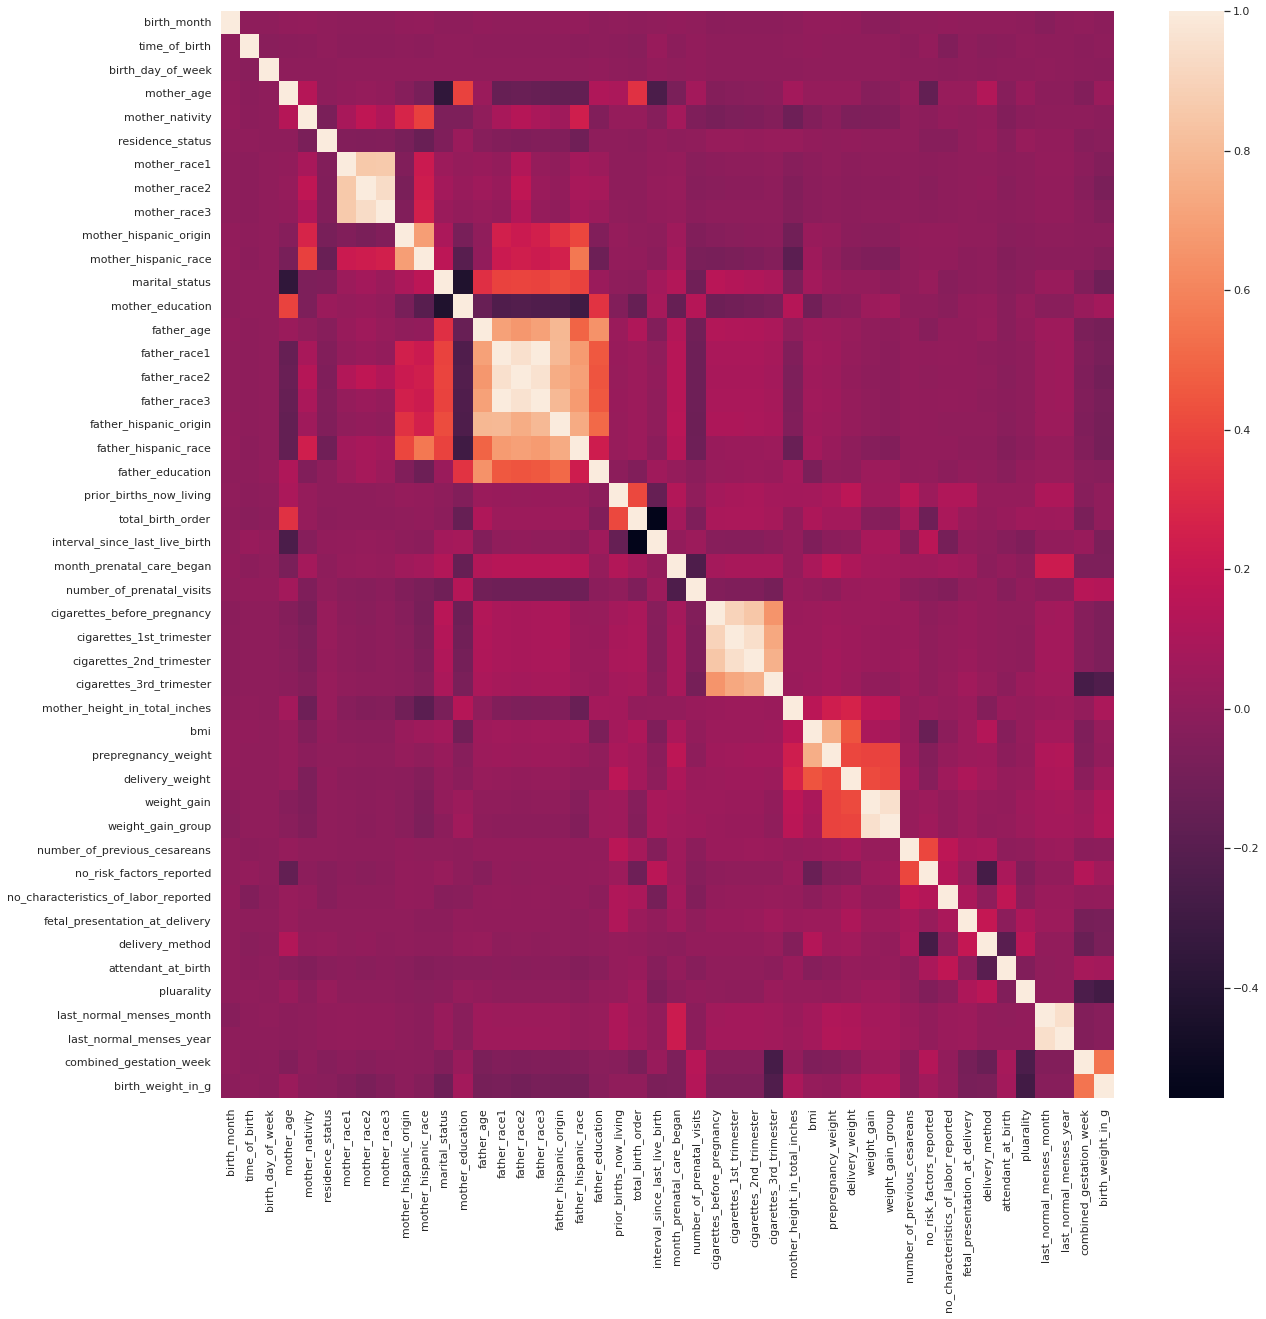

In [33]:
# check correlation
corr = X_EDA.corr()

plt.figure()
sns.set(rc={'figure.figsize':(50,50)})
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)
plt.show()

In [34]:
# remove highly correlated features

def remove_correlated_features(X_features):
    columns_to_be_dropped = []

    # keep mother_race1 because it has the most groups 31 values
    columns_to_be_dropped.append('mother_race2')
    columns_to_be_dropped.append('mother_race3')
    columns_to_be_dropped.append('mother_hispanic_origin')
    # the same for father's race. However heatmap shows high correlation between father's race2 and hispanic_origin and age
    columns_to_be_dropped.append('father_race1')
    columns_to_be_dropped.append('father_race2')
    columns_to_be_dropped.append('father_race3')
    columns_to_be_dropped.append('father_hispanic_origin')
    columns_to_be_dropped.append('father_hispanic_race') # mother's and father's race are highly correlated

    # cigarettes - keep cigarettes_3rd_trimester before pregnancy
    columns_to_be_dropped.append('cigarettes_before_pregnancy')
    columns_to_be_dropped.append('cigarettes_1st_trimester') 
    columns_to_be_dropped.append('cigarettes_2nd_trimester')
    
    # father's age and education are highly correlated
    columns_to_be_dropped.append('father_education')

    # keep BMI, prepregancy_weight, drop delivery_weight are highly correlated
    columns_to_be_dropped.append('delivery_weight')

    # weight gain - keep weight_gain_group
    columns_to_be_dropped.append('weight_gain')

    # heatmap shows correlation between last_normal_menses_month and year.
    columns_to_be_dropped.append('last_normal_menses_year')

    X_features = X_features.drop(columns_to_be_dropped, axis=1, errors='ignore')
    print(X_features.shape)
    return X_features

X_EDA = remove_correlated_features(X_EDA)


(3664641, 48)


In [35]:
# remove features that we don't know ahead of time

def features_not_known_ahead(X_features):
    columns_to_be_dropped = []

    columns_to_be_dropped.append('time_of_birth')
    columns_to_be_dropped.append('birth_day_of_week')
    columns_to_be_dropped.append('induction_of_labor')
    columns_to_be_dropped.append('augmentation_of_labor')
    columns_to_be_dropped.append('steriods')
    columns_to_be_dropped.append('antibiotics')
    columns_to_be_dropped.append('anesthesia')
    columns_to_be_dropped.append('no_characteristics_of_labor_reported')
    columns_to_be_dropped.append('fetal_presentation_at_delivery')
    columns_to_be_dropped.append('delivery_method')

    X_features = X_features.drop(columns_to_be_dropped, axis=1, errors='ignore')
    print(X_features.shape)
    return X_features

X_EDA = features_not_known_ahead(X_EDA)

(3664641, 38)


In [36]:
# check data type - numerical or categorical
for feature in X_EDA.columns:
    print(f"{feature} = {X_EDA[feature].dtype}")
          

birth_month = int64
mother_age = int64
mother_nativity = int64
residence_status = int64
mother_race1 = int64
mother_hispanic_race = int64
paternity_acknowledged = object
marital_status = float64
mother_education = int64
father_age = int64
prior_births_now_living = int64
total_birth_order = int64
interval_since_last_live_birth = int64
month_prenatal_care_began = int64
number_of_prenatal_visits = int64
wic = object
cigarettes_3rd_trimester = int64
mother_height_in_total_inches = int64
bmi = int64
prepregnancy_weight = int64
weight_gain_group = int64
gestational_diabetes = object
prepregnancy_hypertension = object
gestational_hypertension = object
previous_preterm_birth = object
infertility_treatment_used = object
fertility_enhancing_drugs = object
previous_cesarean = object
number_of_previous_cesareans = int64
no_risk_factors_reported = int64
chlamydia = object
attendant_at_birth = int64
pluarality = int64
sex_of_infant = object
last_normal_menses_month = int64
combined_gestation_week = 

In [37]:
# plot feature vs birthweight

# it takes a few minutes to generate the charts
def feature_vs_output(X_features, output_feature):
  '''Function to plot boxplots for all features vs. output'''

  categorical_features = [feature for feature in X_features.columns]
  train_categorical = X_EDA[categorical_features]
  train_categorical.fillna("NA", inplace=True)

  fig, axs = plt.subplots(nrows=len(categorical_features)) # Create figure and subplots
  fig.set_size_inches(10, 6*len(categorical_features)) # Set figure size
  for i,feature_name in enumerate(categorical_features): # Iterate through features for plotting
    sns.boxplot(x=feature_name, y=output_feature, data=train_categorical, ax=axs[i]) # Generate boxplot
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90) # Rotate tick labels for easier viewing
    axs[i].title.set_text(f"{feature_name} vs {output_feature}") # Set title for each subplot


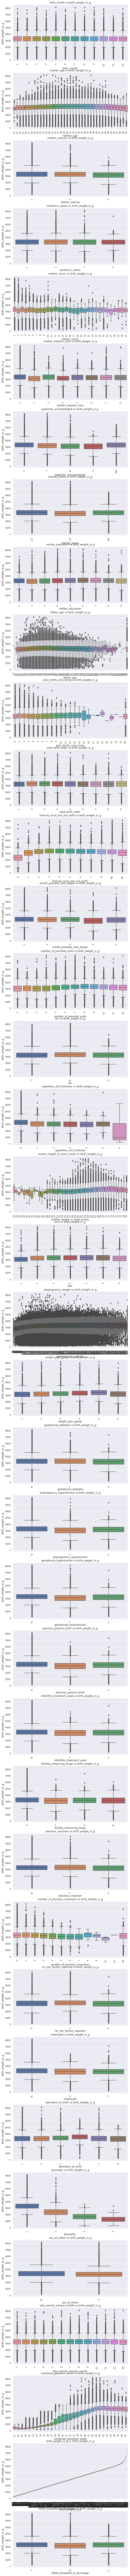

In [38]:
feature_vs_output(X_EDA, "birth_weight_in_g")

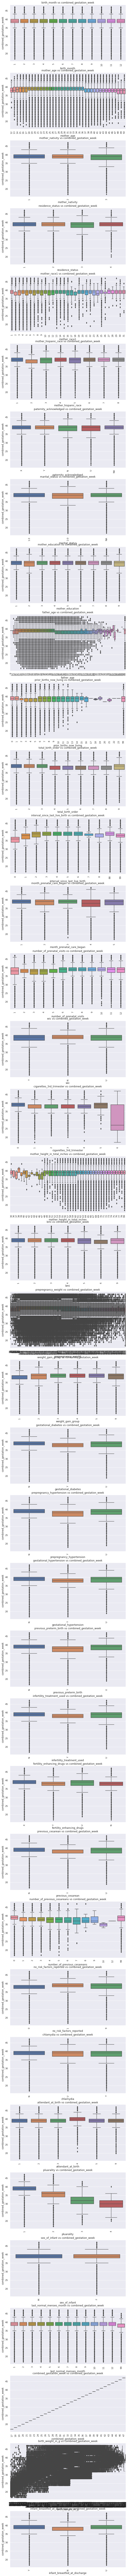

In [39]:
feature_vs_output(X_EDA, "combined_gestation_week")

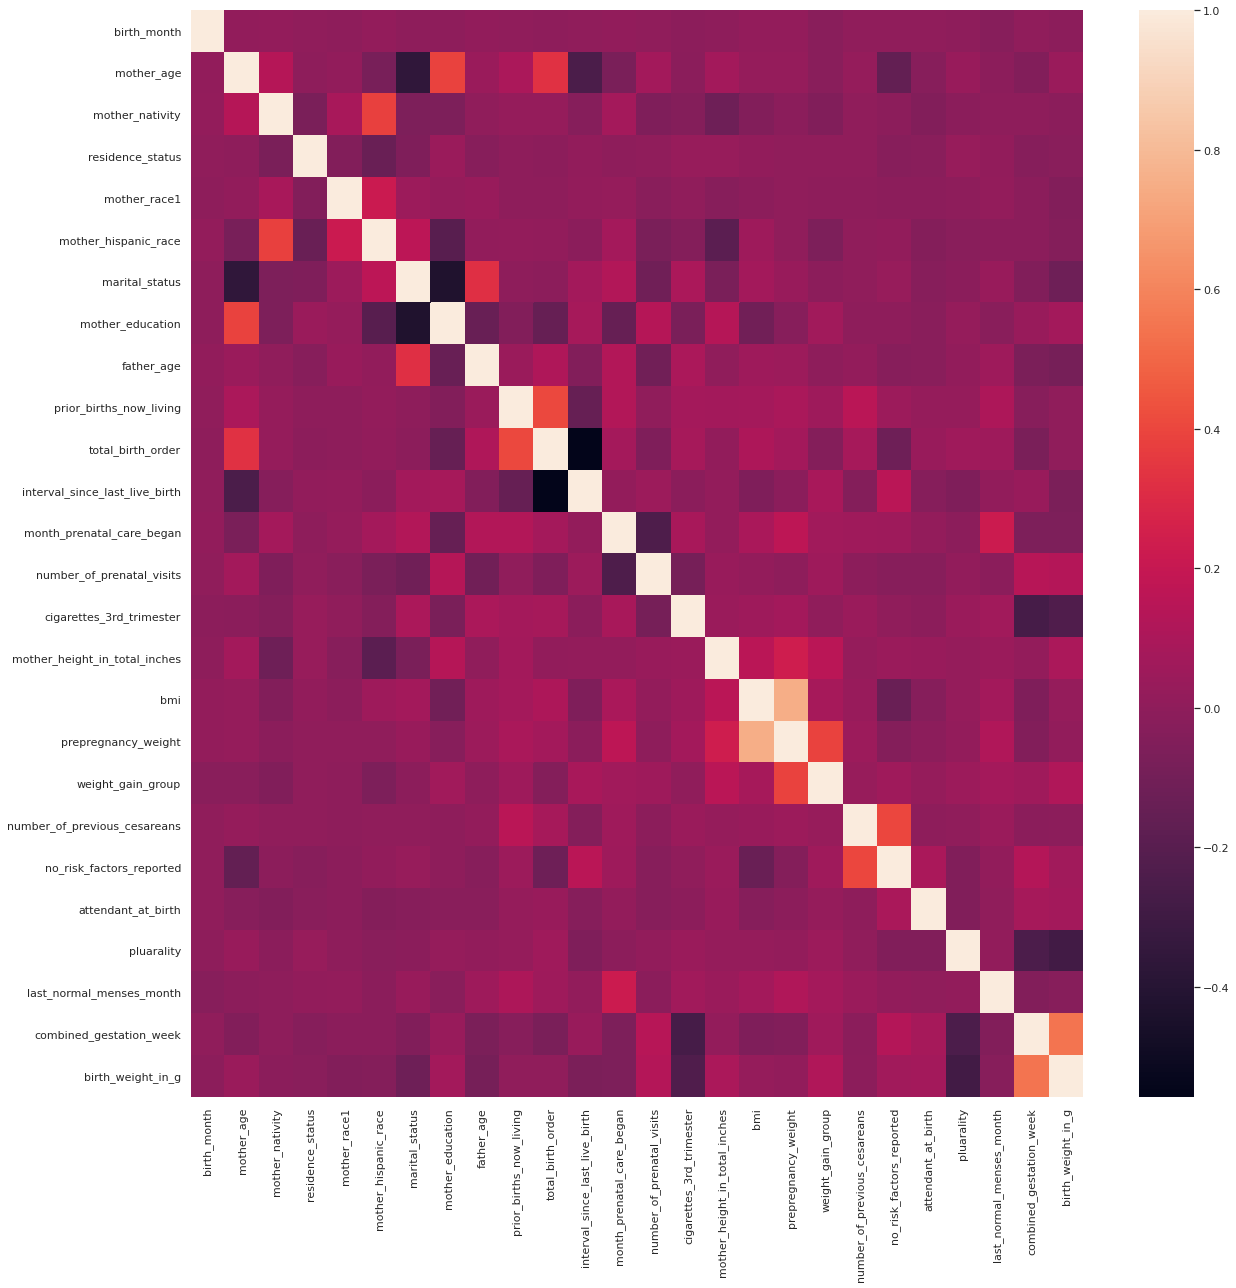

In [40]:
# check correlation
corr = X_EDA.corr()

#plt.figure()
sns.set(rc={'figure.figsize':(20,20)})
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)
plt.show()

### Save the feature list for modeling

In [41]:
# save the feature_list

filename = "/content/drive/MyDrive/w210-capstone/Colab/models/feature_list.txt"
# local jupyter notebook filename="models/feature_list.txt"

np.savetxt(filename, X_EDA.columns.to_numpy(), fmt="%s")
display(X_EDA)


,birth_month,mother_age,mother_nativity,residence_status,mother_race1,mother_hispanic_race,paternity_acknowledged,marital_status,mother_education,father_age,...,number_of_previous_cesareans,no_risk_factors_reported,chlamydia,attendant_at_birth,pluarality,sex_of_infant,last_normal_menses_month,combined_gestation_week,birth_weight_in_g,infant_breastfed_at_discharge
0,1,22,1,1,1,7,X,1.0,3,23,...,0,1,N,1,1,M,4,39,3670,Y
1,1,31,1,2,22,6,Y,2.0,4,27,...,0,1,N,1,1,F,4,39,3210,Y
2,1,29,1,1,1,1,Y,2.0,4,29,...,0,0,N,3,1,F,3,40,3997,Y
3,1,39,1,1,1,7,Y,2.0,6,40,...,0,0,N,2,1,F,4,39,3510,Y
4,1,20,2,1,5,5,Y,2.0,3,28,...,0,1,N,1,1,F,3,39,3100,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3669921,12,38,1,1,10,6,Y,2.0,6,40,...,0,1,N,1,1,F,3,39,3530,Y
3669922,11,34,1,3,2,2,N,2.0,2,99,...,99,9,N,5,1,F,3,38,3590,N
3669923,12,35,1,1,13,6,X,1.0,6,36,...,0,1,N,3,1,M,3,37,2807,Y
3669925,12,36,1,1,1,1,X,1.0,4,48,...,0,1,N,1,1,M,3,39,2905,Y


In [ ]:
# save data to CSV


In [ ]:
hist = X_train.hist(figsize=(40,40))